# Social Network Analysis

## Required libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


## Load Data

In [2]:
def save_file(filename,var):
    var.to_pickle(filename)
    print('File saved: ',filename)
    
    

In [3]:
def read_file(filename):
    return pd.read_pickle(filename)

Since the samples have already been created and saved you can skip this step and load the data directly.

### Load Entire Dataset

In [4]:
users = read_file('./dataset/data_pickles//users.pickle')

In [5]:
business = read_file('./dataset/data_pickles/business.pickle')


In [6]:
tip = read_file('./dataset/data_pickles/tip.pickle')


In [7]:
checkin = read_file('./dataset/data_pickles/checkin.pickle')

In [8]:
reviews = read_file('./dataset/data_pickles/reviews.pickle')


### Create Samples

#### Create Sample of Users

In [ ]:
# Define the initial set of users
initial_users = ['qVc8ODYU5SZjKXVBgXdI7w', 'j14WgRoU_-2ZE1aw1dXrJg']

In [ ]:
# Define the maximum sample_users size
max_sample_size = 1000

sample_users = users[users['user_id'].isin(initial_users)]
users_to_expand = set(initial_users)

while len(sample_users) < max_sample_size and len(users_to_expand) > 0:
    user_to_expand = users_to_expand.pop()

friends = users[users['user_id'] == user_to_expand]['friends'].iloc[0]

if friends is None:
    friends = []
else:
    friends = friends.split(', ')
    sample_users = pd.concat([sample_users, users[users['user_id'].isin(friends)]])
    users_to_expand.update(friends)

sample_users = sample_users.iloc[:max_sample_size]


In [ ]:
print('Sample size: {}'.format(len(sample_users)))

sample_users['friends'] = sample_users['friends'].apply(lambda x: [f for f in x.split(', ') if f in sample_users['user_id'].values])
sample_users.head()


Sample size: 1000


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"[NSCy54eWehBJyZdG2iE84w, TMLVzNYs-zwwREudyvI08...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","[YSfAlm6XNaym-JOrRjv3Tg, G9Vb6yQ047TC3O_-GG4WZ...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
23,MGPQVLsODMm9ZtYQW-g_OA,Jelena,1807,2008-01-19 22:50:00,17331,10461,13734,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","[F_NG8ZaNVriV_hujoOejIA, ACUVZ4SiN0gni7dzVDm9E...",828,...,167,206,395,130,915,3396,1915,1915,696,470
24,OlJ9vcVFB1iEKcZO-MS3cQ,Joz Joz Joz,348,2006-03-03 08:10:12,2063,1260,1537,"2006,2007,2008,2009,2010,2011,2012","[oSN3M4_WKdlTsnpgqPDiBg, KT2EgE1Nv_-Ms8olYxEuF...",116,...,32,27,47,6,183,543,462,462,87,29
28,4F0IjrUJGAieoWwHnRhIJw,Liliana,254,2007-12-19 02:56:45,410,243,275,"2008,2009,2010,2011,2012,2013,2014",[qVc8ODYU5SZjKXVBgXdI7w],21,...,5,6,3,2,7,25,32,32,1,9


#### Create Sample of Reviews and Businesses from Sample of Users

In [ ]:
# get the reviews of the users in the sample
sample_reviews = reviews[reviews['user_id'].isin(sample_users['user_id'])]

sample_reviews.head()
sample_reviews.shape

(29657, 9)

In [ ]:
# get the businesses from the sample reviews
sample_business = business[business['business_id'].isin(sample_reviews['business_id'])]

sample_business.head()
sample_business.shape

(14825, 14)

In [67]:
# save samples to pickle
save_file('./data/sample_users.pickle', sample_users)

save_file('./data/sample_reviews.pickle', sample_reviews)

save_file('./data/sample_business.pickle', sample_business)

File saved:  ./data/sample_users.pickle
File saved:  ./data/sample_reviews.pickle
File saved:  ./data/sample_business.pickle


### Load Samples <a id='load-samples'></a>

In [23]:
# load samples from pickle
loaded_users_sample = read_file('./data/sample_users.pickle')

loaded_reviews_sample = read_file('./data/sample_reviews.pickle')

loaded_business_sample = read_file('./data/sample_business.pickle')

In [24]:

sample_business = loaded_business_sample
sample_reviews = loaded_reviews_sample
sample_users = loaded_users_sample

# reindex the dataframes
sample_business.reset_index(drop=True, inplace=True)
sample_reviews.reset_index(drop=True, inplace=True)
sample_users.reset_index(drop=True, inplace=True)


## Data Exploration

### Data Cleaning

In [6]:
sample_users.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"[NSCy54eWehBJyZdG2iE84w, TMLVzNYs-zwwREudyvI08...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","[YSfAlm6XNaym-JOrRjv3Tg, G9Vb6yQ047TC3O_-GG4WZ...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,MGPQVLsODMm9ZtYQW-g_OA,Jelena,1807,2008-01-19 22:50:00,17331,10461,13734,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","[F_NG8ZaNVriV_hujoOejIA, ACUVZ4SiN0gni7dzVDm9E...",828,...,167,206,395,130,915,3396,1915,1915,696,470
3,OlJ9vcVFB1iEKcZO-MS3cQ,Joz Joz Joz,348,2006-03-03 08:10:12,2063,1260,1537,"2006,2007,2008,2009,2010,2011,2012","[oSN3M4_WKdlTsnpgqPDiBg, KT2EgE1Nv_-Ms8olYxEuF...",116,...,32,27,47,6,183,543,462,462,87,29
4,4F0IjrUJGAieoWwHnRhIJw,Liliana,254,2007-12-19 02:56:45,410,243,275,"2008,2009,2010,2011,2012,2013,2014",[qVc8ODYU5SZjKXVBgXdI7w],21,...,5,6,3,2,7,25,32,32,1,9


In [7]:
sample_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,rGI8UdsEGiGeETFiu1VK1w,WJnyWEe_YK7JO47fcovBVw,hRHhP3fhMy3LktPyQa3s_A,3,0,0,0,Good choice in Union Station St. Louis. I had...,2008-08-20 08:07:02
1,ep8FfviAfqHNyhpW6MQ2jA,n-lBS02-3yvlY5Q91mmwDA,2S_CEQYBbp8RO1bJm_1mng,2,3,3,4,Hipsters unite! I've never had a good time at...,2005-07-10 17:20:44
2,GY2rCySJI41AXWMXvrDTJg,nnImk681KaRqUVHlSfZjGQ,nFjk0xVI9fNiVN__5g-m8Q,5,4,2,6,Ichicoro Ane gets lots of things right and the...,2018-02-23 22:49:01
3,lLc72XgWAGoWXVI3iGydRw,vr-Rw3nMKIgGrVNT6A7p9g,tQYOAfl33tmP4oWpfyRr6g,5,0,0,0,Although there are countless little Mexican pl...,2014-10-27 15:39:17
4,y1CYqccQLsn8GGXYS4q6tQ,BmThnFPDalpbC1x98aXKaw,VbItL6RDULtnw4YvB6EhVg,1,4,4,3,They served me a frozen pizza and skunked beer...,2008-04-30 14:54:01


In [8]:
sample_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
3,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Restaurants, Italian","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
4,noByYNtDLQAra9ccqxdfDw,H&M,827-833 State St,Santa Barbara,CA,93101,34.420209,-119.700460,3.0,24,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Women's Clothing, Accessories, Children's Clot...","{'Monday': '11:0-18:0', 'Tuesday': '11:0-18:0'..."


In [9]:
# Check for duplicates
print('Number of duplicates:', sample_users.duplicated(subset=['user_id']).sum())
print('Number of duplicates:', sample_reviews.duplicated(subset=['review_id']).sum())
print('Number of duplicates:', sample_business.duplicated(subset=['business_id']).sum())


Number of duplicates: 0
Number of duplicates: 0
Number of duplicates: 0


In [10]:
# Check for missing values
sample_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1000 non-null   object 
 1   name                1000 non-null   object 
 2   review_count        1000 non-null   int64  
 3   yelping_since       1000 non-null   object 
 4   useful              1000 non-null   int64  
 5   funny               1000 non-null   int64  
 6   cool                1000 non-null   int64  
 7   elite               722 non-null    object 
 8   friends             1000 non-null   object 
 9   fans                1000 non-null   int64  
 10  average_stars       1000 non-null   float64
 11  compliment_hot      1000 non-null   int64  
 12  compliment_more     1000 non-null   int64  
 13  compliment_profile  1000 non-null   int64  
 14  compliment_cute     1000 non-null   int64  
 15  compliment_list     1000 non-null   int64  
 16  complim

In [11]:
# Check for missing values
sample_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29657 entries, 0 to 29656
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    29657 non-null  object        
 1   user_id      29657 non-null  object        
 2   business_id  29657 non-null  object        
 3   stars        29657 non-null  int64         
 4   useful       29657 non-null  int64         
 5   funny        29657 non-null  int64         
 6   cool         29657 non-null  int64         
 7   text         29657 non-null  object        
 8   date         29657 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.0+ MB


In [12]:
# Check for missing values
sample_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   14825 non-null  object 
 1   name          14825 non-null  object 
 2   address       14825 non-null  object 
 3   city          14825 non-null  object 
 4   state         14825 non-null  object 
 5   postal_code   14825 non-null  object 
 6   latitude      14825 non-null  float64
 7   longitude     14825 non-null  float64
 8   stars         14825 non-null  float64
 9   review_count  14825 non-null  int64  
 10  is_open       14825 non-null  int64  
 11  attributes    14400 non-null  object 
 12  categories    14822 non-null  object 
 13  hours         12659 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 1.6+ MB


### Data Visualization

#### Create Graph of Users and Friends

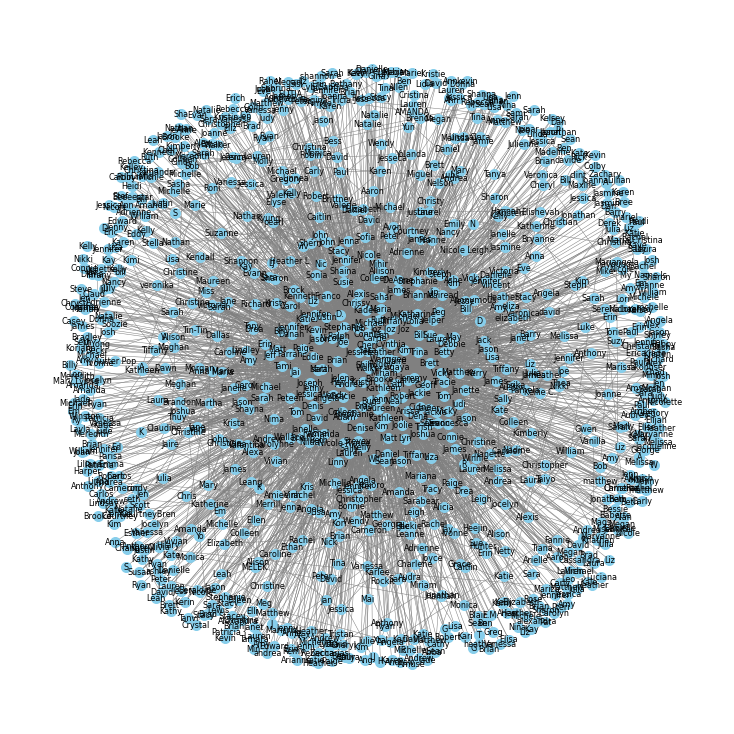

In [13]:
# Create a graph
G = nx.Graph()

for user_id, name in zip(sample_users['user_id'], sample_users['name']):
    G.add_node(user_id, label=name)

for user_id, friends in zip(sample_users['user_id'], sample_users['friends']):
    for friend in friends:
        G.add_edge(user_id, friend)

node_labels = nx.get_node_attributes(G, 'label')
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(10, 10))
nx.draw(G, pos=pos, labels=node_labels, with_labels=True, node_size=100, node_color='skyblue', edge_color='grey', width=0.5, font_size=8)
plt.show()

In [14]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Print the results in a table
pd.DataFrame([degree_centrality, betweenness_centrality, closeness_centrality, eigenvector_centrality], index=['Degree', 'Betweenness', 'Closeness', 'Eigenvector']).T.sort_values('Eigenvector', ascending=False).head(10)


,Degree,Betweenness,Closeness,Eigenvector
qVc8ODYU5SZjKXVBgXdI7w,0.998999,0.910958,0.999000,0.497339
VHdY6oG2JPVNjihWhOooAQ,0.171171,0.009679,0.546798,0.178107
2l0O1EI1m0yWjFo2zSt71w,0.164164,0.008680,0.544711,0.175515
G9Vb6yQ047TC3O_-GG4WZA,0.136136,0.005178,0.536520,0.158411
1kpMAKRZuAz3OzxBav3XTg,0.131131,0.005424,0.535083,0.147475
iLjMdZi0Tm7DQxX1C1_2dg,0.139139,0.006737,0.537386,0.145024
gjhzKWsqCIrpEd9pevbKZw,0.106106,0.003294,0.528013,0.129871
om5ZiponkpRqUNa3pVPiRg,0.113113,0.004031,0.529973,0.126156
UVxY0iyPaqY7s4BSFtt-xA,0.100100,0.002831,0.526344,0.118077
y8aWXOimQ9ZgUgZ6q--nCQ,0.122122,0.005936,0.532516,0.112739


#### Word Cloud of Reviews

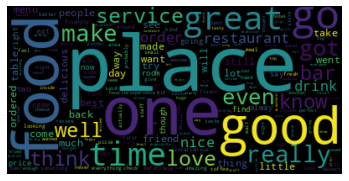

In [15]:
from wordcloud import WordCloud

# assuming `df` is your DataFrame
text = ' '.join(sample_reviews['text'].values)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### World Cloud of Business Categories

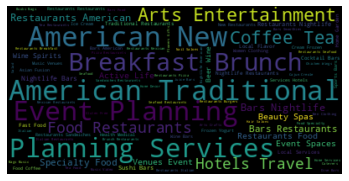

In [16]:
# assuming `sample_business` is your DataFrame and `categories` is the name of the column containing the categories
sample_business = sample_business.dropna(subset=['categories'])
text = ','.join(sample_business['categories'].values)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Mean of Rating in Sample

In [17]:
# mean of the stars of the reviews of the sample
sample_reviews['stars'].mean()

3.8434096503355026

#### Number of Reviews per Category

To do this we use NLP techniques to extract the category from the list of categories for each business. Since there are multiple and similar categories for each business we use tNLP techinques and clustering to get a unique category for each business.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

def cluster_categories(sample):
    categories = sample['categories'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

    # vectorize the text data
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(categories)

    kmeans = KMeans(n_clusters=5)
    kmeans.fit(X)

    categories = categories.to_frame(name='category')

    categories['cluster'] = kmeans.labels_

    clustered_categories = categories.groupby('cluster')

    cluster_names = []

    for cluster, group in clustered_categories:
        X = vectorizer.transform(group['category'])

        lda = LatentDirichletAllocation(n_components=1)
        lda.fit(X)

        words = vectorizer.get_feature_names()
        topic_word = words[np.argmax(lda.components_[0])]

        cluster_names.append(topic_word)

    cluster_sizes = clustered_categories.size().reset_index(name='Review Count')
    cluster_sizes['name'] = cluster_names
    
    return cluster_sizes


/home/carlosmgomes/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


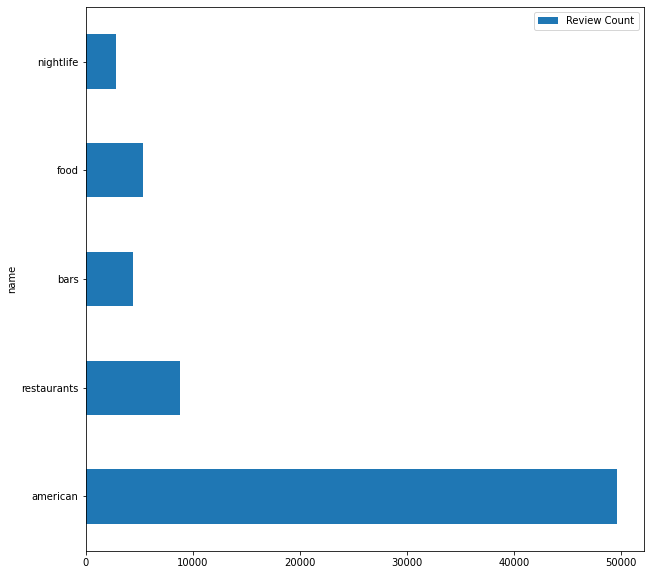

In [19]:
# plot the distribution of clusters using the general category names
cluster_categories(sample_business).plot(x='name', y='Review Count', kind='barh', figsize=(10, 10))
plt.show()

## Social Network Analysis

### Create a Weighted Bipartite Graph (nodes: users and businesses, edges: reviews, weight: review rating)

In [25]:
B = nx.Graph()

B.add_nodes_from(sample_users['user_id'], bipartite=0)
B.add_nodes_from(sample_business['business_id'], bipartite=1)

for index, row in sample_reviews.iterrows():
    B.add_edge(row['user_id'], row['business_id'], weight=row['stars'])


In [21]:
print('Number of nodes:', B.number_of_nodes())
print('Number of edges:', B.number_of_edges())

Number of nodes: 15825
Number of edges: 28424


### Calculate centrality measures

#### Degree Centrality

In [22]:
nodes = tqdm(B.nodes)

degree_centrality = {}
for node in nodes:
    degree_centrality[node] = nx.degree_centrality(B)[node]
    nodes.set_description(f"Processing node {node}")

Processing node v3T-TMoaxN1dWj7oq3E6bg: 100%|██████████| 15825/15825 [02:24<00:00, 109.64it/s]


##### Get Top/Bottom 10 Users/Businesses by Degree Centrality

In [26]:
# Create a dictionary of degree centrality values for user nodes
user_degree_centrality = {node: centrality for node, centrality in degree_centrality.items() if B.nodes[node]['bipartite'] == 0}

# Sort the results to find the 10 most central users
sorted_user_degree_centrality = sorted(user_degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_users = [user[0] for user in sorted_user_degree_centrality[:10]]

# Sort the results to find the 10 least central users
sorted_user_degree_centrality = sorted(user_degree_centrality.items(), key=lambda x: x[1])
bottom_10_users = [user[0] for user in sorted_user_degree_centrality[:10]]

# Create a dictionary of degree centrality values for business nodes
business_degree_centrality = {node: centrality for node, centrality in degree_centrality.items() if B.nodes[node]['bipartite'] == 1}

# Sort the results to find the 10 most central businesses
sorted_business_degree_centrality = sorted(business_degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_businesses = [business[0] for business in sorted_business_degree_centrality[:10]]

# Sort the results to find the 10 least central businesses
sorted_business_degree_centrality = sorted(business_degree_centrality.items(), key=lambda x: x[1])
bottom_10_businesses = [business[0] for business in sorted_business_degree_centrality[:10]]

In [27]:
# merge info of users and businesses
top_10_users_info = sample_users[sample_users['user_id'].isin(top_10_users)]
top_10_businesses_info = sample_business[sample_business['business_id'].isin(top_10_businesses)]
bottom_10_users_info = sample_users[sample_users['user_id'].isin(bottom_10_users)]
bottom_10_businesses_info = sample_business[sample_business['business_id'].isin(bottom_10_businesses)]

In [28]:
top_10_users_info

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
177,84HvpQDxcHWmbMDfs8IEYw,Chrissy,534,2007-05-16 18:41:55,2121,1180,1416,NaN,"[_vN1zUgCxvfVFabQJw5JvA, BmThnFPDalpbC1x98aXKa...",54,...,5,1,12,3,73,64,92,92,17,5
189,nnImk681KaRqUVHlSfZjGQ,Carlos,1107,2006-07-18 20:46:04,4887,1663,3165,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","[3wmJc1Bn99Nx9UtO3MIfiw, M1cMsRL4L7IUr9RILDywE...",259,...,34,17,7,15,160,364,242,242,141,60
318,_ntA5HPDzqBgwg7S3s7w7Q,Sabrina,848,2008-03-15 11:18:32,3300,927,2512,"2014,2015,2016,2017,2018,2019,20,20,2021","[WkBSBfRRloP6QFH7O8I5dg, qVc8ODYU5SZjKXVBgXdI7w]",65,...,18,3,2,0,130,240,322,322,189,156
322,y8aWXOimQ9ZgUgZ6q--nCQ,Carrie,472,2007-11-07 15:25:43,5077,4020,4422,"2007,2008","[XkfnvonaC34N7vumff3Kag, sVEBxKJ53qbzyyoK6edXp...",178,...,30,26,95,35,311,665,518,518,109,54
359,vr-Rw3nMKIgGrVNT6A7p9g,Jamie,554,2008-03-06 15:18:14,1199,351,685,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","[qVc8ODYU5SZjKXVBgXdI7w, sVEBxKJ53qbzyyoK6edXpQ]",74,...,21,8,8,12,37,53,72,72,39,14
513,hL-p_AOo53wJyYrggzYMVg,Robin,375,2008-03-10 19:57:37,790,203,262,"2010,2011","[7UN0GtEVQ3qkw9runiTDpA, iNWfLMXuXG19fpLzTMylk...",44,...,3,2,5,4,16,17,23,23,18,4
539,pgQurApfbrV-rPKZKYo-Tw,Ryan,490,2007-10-19 10:52:43,1042,328,462,"2008,2009,2010,2011,2012,2013,2014,2015","[qVc8ODYU5SZjKXVBgXdI7w, sDGwhNAQIubV36t_fex6V...",39,...,15,2,0,10,46,44,49,49,31,0
540,0yYCMhDWCEIVUyZLzDWwqQ,Caitlin,398,2007-01-23 19:36:16,1021,380,606,2007,"[gpqGjIHlvUKDTttna4wcZQ, _vN1zUgCxvfVFabQJw5Jv...",80,...,11,3,10,4,15,12,12,12,24,9
749,NyqoJTiKgXi1h7MDJDGbxg,Aaron,343,2008-03-11 17:30:16,524,98,189,2010,"[1kpMAKRZuAz3OzxBav3XTg, qVc8ODYU5SZjKXVBgXdI7...",8,...,1,2,0,0,3,9,7,7,1,0
939,bJ5FtCtZX3ZZacz2_2PJjA,Bill,1512,2007-07-13 04:00:59,8735,3041,6564,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","[wLTB11ktAIBJxmktmegQTQ, YD2f5_wTbRWwJ238-DMZP...",287,...,34,17,19,57,272,517,630,630,213,49


In [29]:
top_10_businesses_info

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
495,GBTPC53ZrG1ZBY3DT8Mbcw,Luke,333 Saint Charles Ave,New Orleans,LA,70130,29.950742,-90.070416,4.0,4554,1,"{'RestaurantsReservations': 'True', 'Restauran...","German, Restaurants, Seafood, Cocktail Bars, F...","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."
1498,cXSyVvOr9YRN9diDkaWs0Q,Honey's Sit-N-Eat,800 N 4th St,Philadelphia,PA,19123,39.963990,-75.144482,4.0,1396,1,"{'RestaurantsTakeOut': 'True', 'OutdoorSeating...","Southern, Restaurants, American (Traditional)","{'Monday': '9:0-14:0', 'Tuesday': '9:0-14:0', ..."
2190,mhrW9O0O5hXGXGnEYBVoag,Jacques-Imo's Cafe,8324 Oak St,New Orleans,LA,70118,29.949042,-90.132229,4.5,2406,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Seafood, Cajun/Creole, Restaurants, Vegetarian","{'Monday': '0:0-0:0', 'Wednesday': '17:0-21:0'..."
3253,_C7QiQQc47AOEv4PE3Kong,Commander's Palace,1403 Washington Ave,New Orleans,LA,70130,29.928735,-90.084196,4.5,4876,1,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","French, Restaurants, Cocktail Bars, Nightlife,...","{'Monday': '0:0-0:0', 'Tuesday': '18:0-21:30',..."
5802,IkY2ticzHEn4QFn8hQLSWg,Geno's Steaks,1219 S 9th St,Philadelphia,PA,19147,39.933837,-75.158814,2.5,3401,1,"{'RestaurantsReservations': 'False', 'Corkage'...","Sandwiches, Cheesesteaks, Steakhouses, Restaur...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
7245,qclZoDz3sjT7v5xOSj5P2Q,Lafitte's Blacksmith Shop Bar,941 Bourbon St,New Orleans,LA,70116,29.961033,-90.063619,4.0,1599,1,"{'RestaurantsAttire': ''casual'', 'NoiseLevel'...","Nightlife, Local Flavor, Dive Bars, Bars","{'Monday': '10:30-3:0', 'Tuesday': '10:30-3:0'..."
9974,iSRTaT9WngzB8JJ2YKJUig,Mother's Restaurant,401 Poydras St,New Orleans,LA,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '..."
11246,_ab50qdWOk0DdB6XOrBitw,Acme Oyster House,724 Iberville St,New Orleans,LA,70130,29.954273,-90.068965,4.0,7568,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': ''fu...","Live/Raw Food, Seafood, Restaurants, Cajun/Creole","{'Monday': '11:0-22:0', 'Thursday': '11:0-22:0..."
11268,PP3BBaVxZLcJU54uP_wL6Q,Pat's King of Steaks,1237 E Passyunk Ave,Philadelphia,PA,19147,39.933201,-75.159266,3.0,4250,1,"{'RestaurantsReservations': 'False', 'Corkage'...","Italian, American (Traditional), Sandwiches, F...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
14168,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,51 N 12th St,Philadelphia,PA,19107,39.953341,-75.158855,4.5,5721,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Candy Stores, Shopping, Department Stores, Fas...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."


In [30]:
bottom_10_users_info

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
44,k5vAqz4dTDeD9zDMweULRQ,Kimberly,161,2006-11-07 04:43:16,102,34,53,NaN,"[iChrn349gyWB-8UGyn8a6Q, qVc8ODYU5SZjKXVBgXdI7w]",4,...,1,0,0,0,3,2,6,6,3,0
56,U8BAWPaPPe9sUp7m0k2fdg,Lillian,41,2007-06-26 20:12:13,113,70,90,NaN,"[K7thO1n-vZ9PFYiC7nTR2w, 1kpMAKRZuAz3OzxBav3XT...",4,...,5,0,1,0,5,3,9,9,2,2
62,KtUS6HMhgIPHXuwwkwReEw,Kim,405,2007-12-18 19:50:48,5886,5640,5230,"2008,2009,2010,2011,2012,2013,2014","[ASvjSBCYRd4GhOtSIn8Gyw, iChrn349gyWB-8UGyn8a6...",254,...,87,144,333,37,319,1359,1394,1394,562,383
145,4lpAu8nFqMv1nXz5NLfcXw,Shirley,450,2006-09-25 01:29:30,435,97,272,"2018,2019,20,20,2021","[qVc8ODYU5SZjKXVBgXdI7w, G9Vb6yQ047TC3O_-GG4WZ...",27,...,4,2,0,0,7,31,25,25,10,14
151,yv60ny6vAK6qDzzsK34Zkw,Valentina,256,2007-12-19 23:18:19,1539,1172,1400,"2008,2009,2010","[5HqZ3UJc_f4KD6qtcmyd7w, 71eef6Txk4ZH9IcFFg6Bh...",45,...,11,3,13,4,105,271,373,373,89,12
154,ps5HcO2DL3UpbDxhhFcwgA,Jonathan,200,2006-09-01 02:23:23,120,33,78,2007,"[jNsPTMmg9EcqY7q2Q-Rm6A, qVc8ODYU5SZjKXVBgXdI7w]",5,...,6,1,0,2,2,5,5,5,0,1
175,2G9534Zx7ph7y9k_QhbMOw,Serena,310,2007-11-26 18:07:10,1474,1075,1363,"2008,2009,2010,2011,2012,2013,2014","[H2WhI7u2Zc-ozPnKBvhWwQ, wsc6EkWfDnru6vmS3e5On...",95,...,29,10,16,5,88,131,181,181,142,27
187,gSNYcNNzeSstbK8Ew1uo8A,Aurora,100,2008-01-23 23:45:02,328,162,181,NaN,"[qVc8ODYU5SZjKXVBgXdI7w, rMsB82tk9uOB6JumPMgczg]",69,...,13,7,8,0,33,31,42,42,30,18
191,lLi9S_R99sfrLNy2H7idBg,Angela,341,2007-10-08 07:41:54,881,282,360,"2009,2010,2011,2012,2013,2014,2015","[ACUVZ4SiN0gni7dzVDm9EQ, qVc8ODYU5SZjKXVBgXdI7w]",25,...,5,1,8,2,22,33,42,42,34,5
254,RverJJOG5ZAjd8r33_MyHw,W,15,2007-10-10 01:48:32,30,8,12,NaN,"[qVc8ODYU5SZjKXVBgXdI7w, 5MCBLBxr10NLUKZ4AboAM...",3,...,0,0,0,0,1,2,3,3,0,0


In [31]:
bottom_10_businesses_info

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
4,noByYNtDLQAra9ccqxdfDw,H&M,827-833 State St,Santa Barbara,CA,93101,34.420209,-119.700460,3.0,24,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Women's Clothing, Accessories, Children's Clot...","{'Monday': '11:0-18:0', 'Tuesday': '11:0-18:0'..."
5,x9K0RfZaT_zlw6DklBDzjw,Gavi Italian Restaurant,"7401 N La Cholla Blvd, Ste 146",Tucson,AZ,85707,32.221667,-110.925833,3.5,9,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsRe...","Italian, Restaurants",None
6,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,PA,19104,39.954573,-75.194894,3.0,56,1,"{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...","Restaurants, Automotive, Delis, Gas Stations, ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
9,1MeIwdbTnZOBFCKOrgaxuw,Ricardo's Italian Cafe,1931 Park Ave,Saint Louis,MO,63104,38.617272,-90.212784,3.5,80,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","American (New), Restaurants, Cafes, Italian, A...","{'Monday': '11:0-14:0', 'Tuesday': '16:0-21:0'..."
11,VrGxoSNZfSiT-G4OqRRGIw,Sunset 44 Bistro,118 W Adams Ave,Saint Louis,MO,63122,38.583223,-90.407187,4.0,73,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Bars, Lounges, American (New), Restaurants, Ni...","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."
13,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,1800 Spring Garden St,Philadelphia,PA,19130,39.963078,-75.168027,3.0,137,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Chinese","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:30',..."
15,G4lRmwDHdvhZAhmtlsYYBw,Wendy's,741 Thompson Ln,Nashville,TN,37204,36.112076,-86.767446,1.5,37,1,"{'RestaurantsPriceRange2': '1', 'BikeParking':...","Burgers, Restaurants, Fast Food","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."


##### Compare the Top 10 Users by plotting the number of users as elite per year

/tmp/ipykernel_606165/272867546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_users_info['elite'] = top_10_users_info['elite'].str.replace('20,20', '2020')
/tmp/ipykernel_606165/272867546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_10_users_info['elite'] = bottom_10_users_info['elite'].str.replace('20,20', '2020')


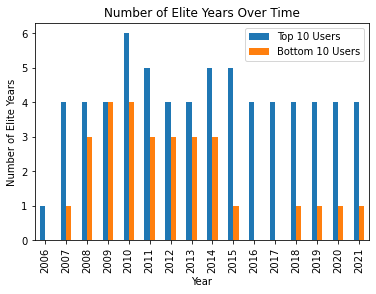

In [32]:
top_10_users_info['elite'] = top_10_users_info['elite'].str.replace('20,20', '2020')
bottom_10_users_info['elite'] = bottom_10_users_info['elite'].str.replace('20,20', '2020')

# split the elite column into lists of strings
top_10_elite_years = top_10_users_info['elite'].str.split(',')
bottom_10_elite_years = bottom_10_users_info['elite'].str.split(',')

# transform the lists into new DataFrames
top_10_elite_years = top_10_elite_years.explode().to_frame(name='elite_year')
bottom_10_elite_years = bottom_10_elite_years.explode().to_frame(name='elite_year')

# count the number of elite years for each year
top_10_elite_count = top_10_elite_years['elite_year'].value_counts().sort_index()
bottom_10_elite_count = bottom_10_elite_years['elite_year'].value_counts().sort_index()

# create a new index containing all the years
years = sorted(set(top_10_elite_count.index) | set(bottom_10_elite_count.index))

# reindex the Series
top_10_elite_count = top_10_elite_count.reindex(years, fill_value=0)
bottom_10_elite_count = bottom_10_elite_count.reindex(years, fill_value=0)

# create a DataFrame with the data
data = pd.DataFrame({'Year': years, 'Top 10 Users': top_10_elite_count.values, 'Bottom 10 Users': bottom_10_elite_count.values})

# plot the data
data.plot(x='Year', y=['Top 10 Users', 'Bottom 10 Users'], kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Elite Years')
plt.title('Number of Elite Years Over Time')
plt.show()


### Eigenvector Centrality

In [33]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(B)


##### Get Top/Bottom 10 Users/Businesses by Eigenvector Centrality

In [34]:

# Create a dictionary of eigenvector centrality values for user nodes
user_eigenvector_centrality = {node: centrality for node, centrality in eigenvector_centrality.items() if B.nodes[node]['bipartite'] == 0}

# Sort the results to find the 10 most central users
sorted_user_eigenvector_centrality = sorted(user_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_users = [user[0] for user in sorted_user_eigenvector_centrality[:10]]

# Sort the results to find the 10 least central users
sorted_user_eigenvector_centrality = sorted(user_eigenvector_centrality.items(), key=lambda x: x[1])
bottom_10_users = [user[0] for user in sorted_user_eigenvector_centrality[:10]]

# Create a dictionary of eigenvector centrality values for business nodes
business_eigenvector_centrality = {node: centrality for node, centrality in eigenvector_centrality.items() if B.nodes[node]['bipartite'] == 1}

# Sort the results to find the 10 most central businesses
sorted_business_eigenvector_centrality = sorted(business_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_businesses = [business[0] for business in sorted_business_eigenvector_centrality[:10]]

# Sort the results to find the 10 least central businesses
sorted_business_eigenvector_centrality = sorted(business_eigenvector_centrality.items(), key=lambda x: x[1])
bottom_10_businesses = [business[0] for business in sorted_business_eigenvector_centrality[:10]]


In [35]:
# merge info of users and businesses
top_10_users_info = sample_users[sample_users['user_id'].isin(top_10_users)]
top_10_businesses_info = sample_business[sample_business['business_id'].isin(top_10_businesses)]
bottom_10_users_info = sample_users[sample_users['user_id'].isin(bottom_10_users)]
bottom_10_businesses_info = sample_business[sample_business['business_id'].isin(bottom_10_businesses)]


In [ ]:
top_10_users_info

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
1044,ET3TgSSQ3shm2mj5vZ8IVQ,Sara,297,2007-12-26 21:22:36,1189,370,941,"2008,2009,2010,2011,2012,2013","[qicIS3yRlQg99Y7Egj0VzQ, QX5xc3lzqhf6O_RAz-Abd...",33,...,6,2,10,11,35,52,114,114,23,6
1969,84HvpQDxcHWmbMDfs8IEYw,Chrissy,534,2007-05-16 18:41:55,2121,1180,1416,NaN,"[_vN1zUgCxvfVFabQJw5JvA, BmThnFPDalpbC1x98aXKa...",54,...,5,1,12,3,73,64,92,92,17,5
3125,6O0MxTs3Pzzj5cXSHgYmrw,Nicole,311,2007-01-21 05:09:03,550,175,326,2007,"[SRnCpcuVZlj6EAa8B51oLg, lLV8s1Su7oet2BEGr9U0G...",33,...,3,3,2,7,6,9,16,16,4,2
3792,y8aWXOimQ9ZgUgZ6q--nCQ,Carrie,472,2007-11-07 15:25:43,5077,4020,4422,"2007,2008","[XkfnvonaC34N7vumff3Kag, sVEBxKJ53qbzyyoK6edXp...",178,...,30,26,95,35,311,665,518,518,109,54
4350,Mf2NAhMTiYk0DC0fZjhNMw,Sally,341,2006-07-07 02:33:53,422,86,183,"2007,2008,2009,2010,2011","[6O0MxTs3Pzzj5cXSHgYmrw, IHOCvB0ZZ9_pLx509U3tp...",11,...,4,4,2,0,24,8,17,17,3,1
4527,gpqGjIHlvUKDTttna4wcZQ,Kimberly,445,2007-06-08 02:14:24,992,378,385,"2009,2010,2011,2014","[RdJ7Ykelg8w4y5FTmxjT8g, qVc8ODYU5SZjKXVBgXdI7...",32,...,10,2,4,1,12,17,29,29,14,2
6471,RdJ7Ykelg8w4y5FTmxjT8g,Kelly,304,2007-06-11 19:46:58,1077,174,433,"2008,2009,2010","[aqWXHhcR_CdmKmxggFOlEA, _vN1zUgCxvfVFabQJw5Jv...",31,...,3,2,0,3,19,22,25,25,10,1
7273,0yYCMhDWCEIVUyZLzDWwqQ,Caitlin,398,2007-01-23 19:36:16,1021,380,606,2007,"[gpqGjIHlvUKDTttna4wcZQ, _vN1zUgCxvfVFabQJw5Jv...",80,...,11,3,10,4,15,12,12,12,24,9
7736,suRoi6fJjOSdzBMWzaZ5sQ,Anna Marie,460,2006-04-20 20:15:17,1520,722,1084,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","[sTpDaUM6Hw4IyHijFyZO5g, 84HvpQDxcHWmbMDfs8IEY...",56,...,10,2,0,0,46,40,105,105,35,7
198836,bJ5FtCtZX3ZZacz2_2PJjA,Bill,1512,2007-07-13 04:00:59,8735,3041,6564,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","[wLTB11ktAIBJxmktmegQTQ, YD2f5_wTbRWwJ238-DMZP...",287,...,34,17,19,57,272,517,630,630,213,49


In [36]:
top_10_businesses_info

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3707,4hv1n1VBzMvE-T4UtIcOcw,Di Bruno Bros.,1730 Chestnut St,Philadelphia,PA,19103,39.951311,-75.170065,4.0,550,1,"{'RestaurantsReservations': 'False', 'GoodForK...","Restaurants, Coffee & Tea, Breakfast & Brunch,...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-20:0', ..."
5113,Co3Ogqy6y2JgZdG0wBlrUQ,Ten Stone Bar & Restaurant,2063 South St,Philadelphia,PA,19146,39.945046,-75.176973,3.0,300,1,"{'WiFi': 'u'free'', 'RestaurantsAttire': ''cas...","Asian Fusion, Nightlife, Restaurants, American...","{'Monday': '11:30-2:0', 'Tuesday': '11:30-2:0'..."
5514,cdrMvOVFFBSwYHb3s06U9w,Septa 5th Street Station,1234 Market St,Philadelphia,PA,19107,39.950684,-75.149102,2.0,250,1,None,"Hotels & Travel, Transportation, Public Transp...","{'Monday': '6:0-20:0', 'Tuesday': '6:0-20:0', ..."
8328,WMkiheTT-8kRslImVLWMVw,Standard Tap,901 N 2nd St,Philadelphia,PA,19123,39.964140,-75.140514,4.0,785,1,"{'RestaurantsPriceRange2': '2', 'WiFi': 'u'fre...","Local Flavor, American (Traditional), Restaura...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '..."
8449,WxB8498ejPtHE7wFa89_fA,The Continental Mid-town,1801 Chestnut St,Philadelphia,PA,19103,39.951931,-75.170453,3.5,1682,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsPri...","Breakfast & Brunch, Lounges, Bars, Cocktail Ba...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-22:0', ..."
10136,W06QBC9vkxA5CVBNVrOMRA,North Third,801 N 3rd St,Philadelphia,PA,19123,39.963506,-75.142782,4.0,677,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Bars, Food, Beer, Wine & Spirits, Nightlife, P...","{'Monday': '16:0-22:0', 'Tuesday': '16:0-22:0'..."
10509,zwgBxmrmPBF6N2uRTUYXrQ,Sugars,225 Church St,Philadelphia,PA,19106,39.950992,-75.144882,3.5,148,0,"{'OutdoorSeating': 'False', 'NoiseLevel': 'u'l...","Pubs, Nightlife, Bars, Restaurants, Dive Bars","{'Wednesday': '12:0-2:0', 'Thursday': '12:0-2:..."
10572,K3RURR9lIEE4JjOaPt99zg,Sabrina's Café,910 Christian St,Philadelphia,PA,19147,39.938871,-75.158236,4.0,1176,0,"{'OutdoorSeating': 'True', 'BusinessAcceptsCre...","Vegetarian, Breakfast & Brunch, American (New)...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
13677,OdIBX09glfXNVSyd0RnIeg,Monk's Cafe,264 S 16th St,Philadelphia,PA,19102,39.947701,-75.168287,4.0,2184,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Nightlife, Pubs, Bars, Belgian, Restaurants, G...","{'Wednesday': '11:30-0:0', 'Thursday': '11:30-..."
14168,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,51 N 12th St,Philadelphia,PA,19107,39.953341,-75.158855,4.5,5721,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Candy Stores, Shopping, Department Stores, Fas...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."


In [37]:
bottom_10_users_info

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
141,tBdUeVfUZln9PlSVfONemQ,Michelle,214,2007-07-04 03:28:27,543,475,383,"2009,2010,2011","[om5ZiponkpRqUNa3pVPiRg, MGPQVLsODMm9ZtYQW-g_O...",19,...,14,14,14,10,35,62,31,31,15,12
350,-Q6Db__tGd2buBKFkvDghw,R,26,2007-10-17 06:41:40,50,22,23,NaN,[qVc8ODYU5SZjKXVBgXdI7w],8,...,3,0,1,0,2,0,3,3,3,1
464,4IjzfbO7XKFNWWVufHNhww,Natalie,759,2007-12-10 04:02:05,1659,814,1049,"2008,2009,2010,2011,2012","[GXn4ZsasLKh0qZ5g3nIqcQ, IkFjRnnI5trMcwHHl_1Vr...",49,...,7,5,15,3,25,67,102,102,21,13
521,UFnGZ2Ii0pAGtqAQ_-v3-Q,Heather,90,2007-07-15 19:09:21,127,29,54,NaN,"[qVc8ODYU5SZjKXVBgXdI7w, iEONL-v4W46yliYsovCP_...",2,...,1,0,1,0,3,4,6,6,3,0
661,KT9-Emtiqng5VDgYy9oF9w,Scott,108,2006-08-16 22:44:16,152,23,67,"2007,2012","[VHdY6oG2JPVNjihWhOooAQ, qVc8ODYU5SZjKXVBgXdI7w]",6,...,2,0,1,0,2,8,5,5,4,0
723,C-SugLUP9zMYVfGrVqAKUw,Kelsey,230,2007-10-09 22:21:44,698,320,477,"2008,2009,2010,2011","[PntWHBXMz37_GHPtjY0_2g, 3nnGpx5WOMiZK1mPDEFLc...",24,...,2,2,4,6,14,32,44,44,31,0
779,35cOznQiCo8pz_NBULvL_w,Remy,126,2007-01-26 06:49:01,273,178,181,"2007,2008,2009","[L5OCs5ri6Wrtpfru5IGuaQ, qVc8ODYU5SZjKXVBgXdI7...",18,...,8,2,6,0,3,9,10,10,10,4
784,CVt21B3lev9ayUZBvjcjXQ,Sera,113,2007-03-27 15:02:27,414,148,104,2010,[qVc8ODYU5SZjKXVBgXdI7w],9,...,4,1,0,0,8,5,7,7,1,4
880,lJV759fL0hG1NO53hAMTeA,Stephanie,20,2007-02-20 04:00:57,65,27,25,NaN,[qVc8ODYU5SZjKXVBgXdI7w],3,...,0,0,0,0,0,1,0,0,1,0
922,v6azJTaGYAROhxnCtDgztA,Colby,50,2007-12-05 15:10:32,167,36,19,NaN,[qVc8ODYU5SZjKXVBgXdI7w],1,...,0,0,0,0,3,7,1,1,1,1


In [38]:
bottom_10_businesses_info

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
333,kdboJGRQZXuKYLIFMvsoJw,Boise Auto Repair Mobile Tech Auto Repair,"1650 W Targee St, Ste 5104",Boise,ID,83705,43.583617,-116.202401,3.5,15,1,"{'HasTV': 'False', 'RestaurantsDelivery': 'Tru...","Hawaiian, Car Stereo Installation, Auto Detail...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
846,gKPWC7F219oEbu5NXPzH4g,Sam's Beach Bar,6325 Clark St,Hudson,FL,34667,28.361939,-82.710341,3.5,555,1,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Seafood, American (Traditional), Music Venues,...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
972,MbzgGsMQpGyVrUJXi_Jw0Q,Dawn Patrol,324 State St,Santa Barbara,CA,93101,34.415730,-119.693661,4.0,807,1,"{'HasTV': 'True', 'ByAppointmentOnly': 'False'...","Coffee & Tea, Breakfast & Brunch, Restaurants,...","{'Monday': '0:0-0:0', 'Wednesday': '8:0-14:0',..."
1204,Ph6-SNyEK_CIOzARiJhG6A,Momma Jammz,91 171st Ave,North Redington Beach,FL,33708,27.819619,-82.824387,4.5,62,0,"{'BusinessParking': '{'garage': False, 'street...","American (New), Restaurants, Food, Sandwiches,...","{'Tuesday': '11:0-17:30', 'Wednesday': '11:0-1..."
1578,u-8sFq05DQ6PYCR5HiKZ2w,Axis Pizza,20 S 36th St,Philadelphia,PA,19104,39.955337,-75.194610,3.0,159,1,"{'RestaurantsDelivery': 'True', 'NoiseLevel': ...","Pizza, Food, Restaurants, Sandwiches, Burgers,...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
9143,FNug6hh4P-Ye4nVgvZcdOg,The Reef,6712 Gulf Blvd,Saint Pete Beach,FL,33706,27.737373,-82.748694,4.0,11,0,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Seafood, Restaurants, American (Traditional)",None
10957,RkkCpZJ2-wHZQtco68pZ5A,"Kimberly K Short, MD",8455 Clearvista Pl,Indianapolis,IN,46256,39.910396,-86.040606,3.5,7,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Laser Hair Removal, Skin Care, Health & Medica...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-19:0', ..."
11286,LO5y-6HMvZ_hmLh1FLVugg,Quadro Supermarket,8401 N Armenia Ave,Tampa,FL,33604,28.026010,-82.483849,3.0,5,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Restaurants, Food, Latin American, Custom Cake...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ..."
12190,yZVm-kuSC6AgLc4FtT45cw,Ramada Tucson,777 W Cushing St,Tucson,AZ,85745,32.216185,-110.980657,2.5,78,1,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Hotels, Hotels & Travel, Event Planning & Serv...","{'Monday': '0:0-23:59', 'Tuesday': '0:0-23:59'..."
12601,oDwX2m4cIX5Hbh4rhZlp5Q,Gillian Institute,317 S Delaware,Indianapolis,IN,46204,39.762145,-86.154493,2.0,6,1,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","Cosmetic Surgeons, Health & Medical, Aesthetic...","{'Monday': '8:30-17:30', 'Tuesday': '8:30-18:0..."


### Link Analysis

### HITS

In [39]:
hubs, authorities = nx.hits(B)

The problem with HITS is that it is irrelevant if the graph is weighted. Therefore, we will create a version of PageRank that works with weighted graphs.

### PageRank

In [40]:
# Create a transition matrix
n = len(B.nodes())
A = nx.adjacency_matrix(B).todense()
P = np.zeros((n,n))
for i in tqdm(range(n)):
    for j in range(n):
        if A[i,j] > 0:
            P[i,j] = A[i,j] / A[i,:].sum()


100%|██████████| 15825/15825 [01:20<00:00, 195.61it/s]


In [41]:
# damping factor 
d = 0.85

# Calculate the PageRank vector
n = len(B.nodes())
r = np.ones((n,1)) / n
for i in tqdm(range(100)):
    r = d * P.T @ r + (1 - d) / n

# Create a dictionary of PageRank scores
pagerank = {}
for i, node in enumerate(B.nodes()):
    pagerank[node] = r[i,0]

100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


In [42]:
# Create a list of businesses sorted by their PageRank scores
businesses = [node for node in B.nodes() if B.nodes[node]['bipartite'] == 1]
businesses_sorted = sorted(businesses, key=lambda x: pagerank[x], reverse=True)

for business in businesses_sorted[:10]:
    temp = sample_business[sample_business['business_id'] == business][['name', 'stars']]
    print(temp.iloc[0]['name'], '({})'.format(temp.iloc[0]['stars']))
    print('PageRank:', pagerank[business])
    print()

Reading Terminal Market (4.5)
PageRank: 0.0006770866771729199

Luke (4.0)
PageRank: 0.0005950590784172992

Acme Oyster House (4.0)
PageRank: 0.0005752954713696911

Honey's Sit-N-Eat (4.0)
PageRank: 0.0005663675880247829

Jacques-Imo's Cafe (4.5)
PageRank: 0.0004942223285499238

Mother's Restaurant (3.5)
PageRank: 0.0004924272717022606

Lafitte's Blacksmith Shop Bar (4.0)
PageRank: 0.0004858538822657366

Commander's Palace (4.5)
PageRank: 0.0004684529755614039

Morimoto (4.5)
PageRank: 0.0004636828945737507

Cochon Butcher (4.5)
PageRank: 0.0004564835189661839



#### With the preivous results we will create a very simple recommendation system using a simple user-based collaborative filtering algorithm

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a user-item matrix
n_users = len(sample_users)
n_items = len(sample_business)
user_item = np.zeros((n_users, n_items))
for index, row in tqdm(sample_reviews.iterrows()): #29657it
    user_index = sample_users[sample_users['user_id'] == row['user_id']].index[0]
    item_index = sample_business[sample_business['business_id'] == row['business_id']].index[0]
    user_item[user_index, item_index] = row['stars']

# Calculate the cosine similarity between users
user_similarity = cosine_similarity(user_item)

# Make recommendations for a target user
target_user = random.choice(range(n_users))
top_k = 5
similar_users = np.argsort(-user_similarity[target_user])[1:top_k+1]
recommended_items = np.argsort(-user_item[similar_users].mean(axis=0))


29657it [00:54, 547.35it/s]


In [44]:
# display the recommendations
print('Recommendations for {} (id: {}):\n'.format(sample_users.iloc[target_user]['name'], sample_users.iloc[target_user]['user_id']))
for i in range(top_k):
    print('{}. {}'.format(i+1, sample_business.iloc[recommended_items[i]]['name']))
    print('Categories: {}'.format(sample_business.iloc[recommended_items[i]]['categories']))


Recommendations for Rebecca (id: Pp4doAlCjxOxemlkTc7ERQ):

1. Fido
Categories: Bakeries, American (Traditional), American (New), Restaurants, Breakfast & Brunch, Sandwiches, Coffee & Tea, Food, Desserts, Cafes
2. Monell's Dining & Catering
Categories: Soul Food, Food, Southern, Diners, American (Traditional), Restaurants, Breakfast & Brunch, Salad
3. Pangaea
Categories: Home Decor, Jewelry, Shopping, Event Planning & Services, Women's Clothing, Flowers & Gifts, Accessories, Cards & Stationery, Arts & Crafts, Home & Garden, Fashion
4. Loveless Cafe
Categories: Food, American (Traditional), Arts & Entertainment, Southern, Nightlife, Restaurants, Breakfast & Brunch, Music Venues
5. Nashville International Airport - BNA
Categories: Car Rental, Hotels & Travel, Transportation, Airports


### Communities Detection

#### Greedy Modularity Communities Detection 

In [45]:
from networkx.algorithms.community import greedy_modularity_communities

greedy_communities = list(greedy_modularity_communities(B))


### Label Propagation Communities Detection

In [46]:
from networkx.algorithms.community import asyn_lpa_communities

lpa_communities = list(asyn_lpa_communities(B))


In [47]:
# get len of communities
print('Number of communities:', len(greedy_communities))
print('Number of communities:', len(lpa_communities))

Number of communities: 64
Number of communities: 597


#### Modularity and Conductance

In [48]:
from networkx.algorithms.community import modularity
from networkx.algorithms.cuts import conductance

def get_community_metrics(communities):
    mod = modularity(B, communities)
    for i in  tqdm(range(len(communities))):
        cond = conductance(B, communities[i])
    return mod, cond

greedy_mod, greedy_cond = get_community_metrics(greedy_communities)
lpa_mod, lpa_cond = get_community_metrics(lpa_communities)

print('Greedy Modularity:', greedy_mod)
print('Greedy Conductance:', greedy_cond)
print('LPA Modularity:', lpa_mod)
print('LPA Conductance:', lpa_cond)


100%|██████████| 597/597 [00:05<00:00, 103.71it/s]

Greedy Modularity: 0.7258012043375048
Greedy Conductance: 0.0
LPA Modularity: 0.5636178174188125
LPA Conductance: 0.3548387096774194


#### Get Average Rating for Biggest Community in both sets of communities

In [49]:
greedy_community = max(greedy_communities, key=len)
lpa_community = max(lpa_communities, key=len)


In [50]:
# assuming `community` is a set representing a single community
user_nodes = [node for node in greedy_community if B.nodes[node]['bipartite'] == 0]
user_ratings = []
for user_node in user_nodes:
    user_data = sample_users[sample_users['user_id'] == user_node]
    user_ratings.append(user_data['average_stars'].values[0])
average_rating = sum(user_ratings) / len(user_ratings)
print('Average rating:', average_rating)


Average rating: 3.76970930232558


In [51]:
# assuming `community` is a set representing a single community
user_nodes = [node for node in lpa_community if B.nodes[node]['bipartite'] == 0]
user_ratings = []
for user_node in user_nodes:
    user_data = sample_users[sample_users['user_id'] == user_node]
    user_ratings.append(user_data['average_stars'].values[0])
average_rating = sum(user_ratings) / len(user_ratings)
print('Average rating:', average_rating)


Average rating: 3.8011111111111107


#### Draw greedy communities

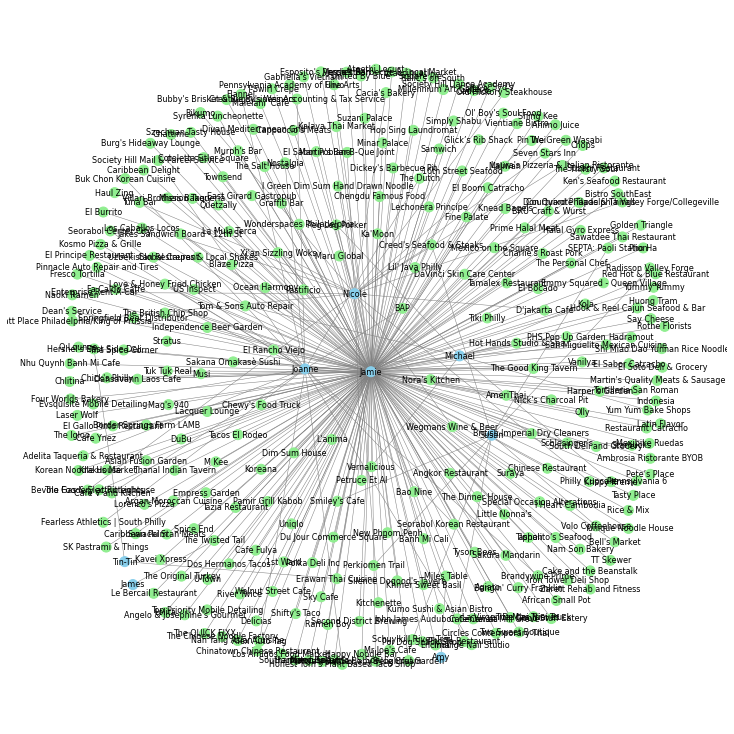

In [53]:
# create a graph of a community using a random community from each algorithm
community = random.choice(greedy_communities)

# create a bipartite graph of the community with user and business names as labels
community_graph = nx.Graph()
for node in community:
    if B.nodes[node]['bipartite'] == 0:
        community_graph.add_node(sample_users[sample_users['user_id'] == node]['name'].values[0])
    else:
        community_graph.add_node(sample_business[sample_business['business_id'] == node]['name'].values[0])

for edge in B.edges:
    if edge[0] in community and edge[1] in community:
        community_graph.add_edge(sample_users[sample_users['user_id'] == edge[0]]['name'].values[0], sample_business[sample_business['business_id'] == edge[1]]['name'].values[0])

plt.figure(figsize=(10, 10))
node_color = []
for node in community_graph.nodes:
    if node in sample_users['name'].values:
        node_color.append('skyblue')
    else:
        node_color.append('lightgreen')

pos = nx.spring_layout(community_graph, k=0.5)
nx.draw(community_graph, pos=pos,with_labels=True, node_size=100, node_color=node_color, edge_color='grey', width=0.5, font_size=8)
plt.show()


### Get reviews that exist in communities that users 1 and 2 belong to

We will save this reviews to test the Recommender System in a community

In [54]:
user1 = 'bJ5FtCtZX3ZZacz2_2PJjA'
user2 = 'nnImk681KaRqUVHlSfZjGQ'

# get the communities that the users belong to 
user1_community = [community for community in greedy_communities if user1 in community][0]
user2_community = [community for community in greedy_communities if user2 in community][0]

# create a boolean mask to filter the rows
mask = (sample_reviews['business_id'].isin(user1_community)) | (sample_reviews['user_id'].isin(user1_community))

# create a new DataFrame containing only the reviews in the community
user1_community_reviews = sample_reviews[mask]

# create a boolean mask to filter the rows
mask = (sample_reviews['business_id'].isin(user2_community)) | (sample_reviews['user_id'].isin(user2_community))

# create a new DataFrame containing only the reviews in the community
user2_community_reviews = sample_reviews[mask]

print('Number of reviews in user1 community:', len(user1_community_reviews))
print('Number of reviews in user2 community:', len(user2_community_reviews))


save_file('./data/user1_community_reviews.pickle', user1_community_reviews)
save_file('./data/user2_community_reviews.pickle', user2_community_reviews)


Number of reviews in user1 community: 9682
Number of reviews in user2 community: 1920
File saved:  ./data/user1_community_reviews.pickle
File saved:  ./data/user2_community_reviews.pickle
